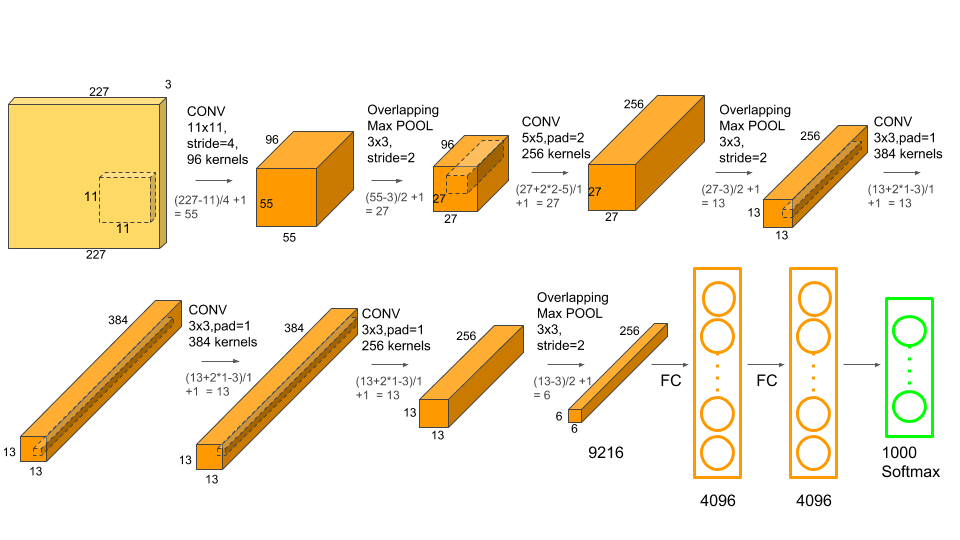

In [1]:
#Alexnet Architecture
import os 
os.getcwd() #check current directory
os.chdir('/Users/jaehyoyi/Desktop/') # move to Desktop directory
from IPython.display import Image, display
#cd /Users/jaehyoyi/Desktop
display(Image(filename='Alexnet.png'))
#picture from : https://medium.com/analytics-vidhya/concept-of-alexnet-convolutional-neural-network-6e73b4f9ee30


In [2]:
#Alexnet code
#Reference : https://github.com/dansuh17/alexnet-pytorch/blob/d0c1b1c52296ffcbecfbf5b17e1d1685b4ca6744/model.py#L40
            #https://ingu627.github.io/code/alexnet_pytorch/


#Import Necessary packages(?)

import os   #In python, use to copy files, make directory, change directory etc
import torch
import torch.nn as nn #nn stands for neural networks --> use attribute to make states
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision        #torch vision packages include datasets, model architecture, image transformation etc
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader


In [11]:
#Define Epoch, batch size, device

epochs = 10
batch_size = 512

device = ("cuda" if torch.cuda.is_available() else "cpu") #Use GPU if avaliable, if not use cpu
class_names = [
    "T-shirt/top", "Trouse", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
] 
#FASHION_MNIST Dataset has 10 classes


print(torch.__version__)
print(device) #check if using cpu or gpu

2.0.1
cpu


In [8]:
#Import more packages(?)
#Prepare Dataset

transform = transforms.Compose([
    transforms.Resize(227),     #FashionMNIST data is 28x28 so has to change to 227x227   
    transforms.ToTensor()   #TO Tensor : PIL image or numpy, ndarray --> tensor로 바꿈
    
])


training_data = datasets.FashionMNIST(
   root="data", #path where to save the data
    train=True, #it is a training dataset
    download = True ,#download from internet
    transform = transform # feature 및 label 변환(transformation) 지정
)

validation_data = datasets.FashionMNIST(
    root="data",
    train=False, #test data
    download=True,
    transform=transform
)




100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [9]:
#Define dataloader
#데이터로더는 데이터를 배치 단위로 모델에 밀어주는 역할, 전체 데이터 가운데 일부를 뽑아 sample를 구성한다

training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

In [11]:
#Look at some images

def matplotlib_imshow(img):
    #function to show an image
    img = img.mean(dim=0)
    img = img/ 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg, cmap = "Greys")


#get some random training images
dataiter = iter(training_loader) #iter --> repeat stuff




